# Setup

## Imports

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sb
import matplotlib.pyplot as plt
import time
from IPython.display import HTML

## Getting the files
1. I downloaded the cleaned [PID](http://www2.cs.uh.edu/~ceick/DM/Pid-clean.csv) and [Complex9](http://www2.cs.uh.edu/~ceick/UDM/DataSets/Complex9.txt) datasets from Dr. Eick's links
2. I used the section called "Accessing local file system using Python code" from this [tutorial](https://neptune.ai/blog/google-colab-dealing-with-files) to upload the .csv to my google colab notebook's directory


In [2]:
pid = files.upload()
complex9 = files.upload()

Saving PID_clean.csv to PID_clean.csv


Saving Complex9.csv to Complex9.csv


## Make the data frames


In [3]:
pid = pd.read_csv("PID_clean.csv", names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"] )
pid.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,156,33.6,0.627,50,1
1,1,85,66,29,156,26.6,0.351,31,0
2,8,183,64,29,156,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
complex9 = pd.read_csv("Complex9.csv")
complex9.head()

,x,y,label
0,660.976,304.225,0
1,636.213,306.174,0
2,662.753,307.565,0
3,657.487,307.740,0
4,635.273,308.157,0


###  Drop unused columns (SkinThickness and Insulin)

In [5]:
pid.drop(columns=["SkinThickness", "Insulin"], inplace=True)
#pid now holds un-normalized data with only the columns we care about
pid.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0
4,0,137,40,43.1,2.288,33,1


### Z score

In [6]:
ZPID = pd.DataFrame(columns = pid.columns[:7])
for col in ZPID.columns:
  if col != "Outcome":
    ZPID[col] = zscore(pid[col])
  else:
    ZPID[col]=pid[col]
#ZPID now holds normalized data with only the columns we care about
ZPID.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.865041,-0.031990,0.167240,0.468492,1.425995,1
1,-0.844885,-1.206228,-0.528319,-0.851551,-0.365061,-0.190672,0
2,1.233880,2.015746,-0.693761,-1.331838,0.604397,-0.105584,1
3,-0.844885,-1.074719,-0.528319,-0.633239,-0.920763,-1.041549,0
4,-1.141852,0.503391,-2.679076,1.549885,5.484909,-0.020496,1


# Subtask A*
Write an function  purity(*a*,*b*,outliers=FALSE) that computes the purity of a clustering result based on an apriori given set of class lables, where *a* gives the assignment of objects in O to clusters, and *b* is the “ground truth”.  Purity is defined as follows: <br />
Let...<br />
* $O$ be a dataset<br />
* $N$ = $|$$O$$|$
* $X$={$C_1$,…,$C_k$} be a clustering of $O$ with $C_i$⊆$O$ (for $i$=1,…,$k$),<br/>
i.e. $C_1$∪…∪$C_k$⊆$O$ and $C_i$∩$C_m$=Ø for $i$ != $m$ <br/>
* $Y$={$y_1$,...,$y_j$} be the set of ground-truth classes of $O$ with $y_i$⊆$O$ (for $i$=1,…,$j$), <br/>
i.e. $y_1$∪…∪$y_j$⊆$O$ and $y_i$∩$y_m$ for $i$ != $m$ <br />


PUR($X$)= (number_of_majority_class_examples($X$)/(total_number_examples_in_clusters($X$)) <br/><br/>

[Alternatively](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html), <br/>
PUR($X$) = $\frac{1}{N}$ $\sum_{k}$ **$max_j$** $|$$C_k$ ∩ $y_j$$|$<br/>
<br/> 


Note:<br/>
* If the used clustering algorithm supports outliers, outliers should be ignored in purity computations.
* If you use R-clustering algorithms, you can assume that cluster 0 contains all the outliers, and clusters 1,2,…,$k$ represent “true” clusters. 
* If the parameter outliers is set to False, the function just returns a floting point number of the observed purity
  * if parameter outliers is set to True the function returns a vector: (purity,percentage_of_outliers)<br/>
   e.g. if the function returns (0.98, 0.2) this would indicate that the purity is 98%, but 20% of the objects in dataset $O$ have been classified as outliers.


In [7]:
def PUR(predicted, actual, outliers=False): #here a = predicted, b = actual
  if len(predicted) != len(actual): # verify we have the same number of elements in each
    print("Error: Unequal number of elements in predicted and actual passed to PUR()")
    return

  def clustersClasses(predicted, actual):
    dictToReturn = dict.fromkeys(set(predicted).union(set(actual)))
    for i in range(len(predicted)):
      if dictToReturn[predicted[i]] == None:
        dictToReturn[predicted[i]] = [actual[i]]
      else:
        dictToReturn[predicted[i]].append(actual[i])
    return dictToReturn
  
  def sumCountsOfMajorityClassInEachCluster(clustersActuals):
    sum = 0
    for actuals in clustersActuals.values():
      maxCount = 0
      if actuals != None:
        for value in set(actuals):
          if actuals.count(value) > maxCount:
            maxCount = actuals.count(value)
      sum += maxCount
    return sum
  
  N = len(predicted)
  clustersActuals = clustersClasses(predicted, actual)

  if outliers:
    # do not consider outliers in purity calculation, return a vector: (purity,percentage_of_outliers)
    numOutliers = list(predicted).count(-1) # -1 as a predicted class indicates an outlier in the return of a DBSCAN clustering
    N -= numOutliers # update N accordingly
    if clustersActuals.get(-1) != None: # there are outliers, remove them with dict.pop()
      clustersActuals.pop(-1)
    sum = sumCountsOfMajorityClassInEachCluster(clustersActuals)
    return (float(sum/N), float(numOutliers/N))

  else: # no outliers to consider,  just returns a floting point number of the observed purity
    sum = sumCountsOfMajorityClassInEachCluster(clustersActuals)
    return float(sum/N)

# Subtask B**
* Run K-means for $k$=9 and $k$=13 for the Complex9 dataset
* Visualize the obtained two clusterings
* Compute their purity using the function you developed in Subtask A
* Assess if the K-means clustering was able to "rediscover" the natural clusters of the Complex9 dataset, captured by the "Outcome" attribute of the dataset

## Run K-means for $k$=2, $k$=9 and $k$=13 using the Complex9 dataset

In [8]:
k9Complex9Clustering = KMeans(n_clusters=9).fit(complex9.iloc[:,:2])
complex9["k9"] = k9Complex9Clustering.labels_
k13Complex9Clustering = KMeans(n_clusters=13).fit(complex9.iloc[:,:2])
complex9["k13"] = k13Complex9Clustering.labels_
complex9.head()

,x,y,label,k9,k13
0,660.976,304.225,0,4,2
1,636.213,306.174,0,4,1
2,662.753,307.565,0,4,2
3,657.487,307.740,0,4,2
4,635.273,308.157,0,4,1


## Visualize the obtained two clusterings
To this end we'll define the following function...

### for $k$=9

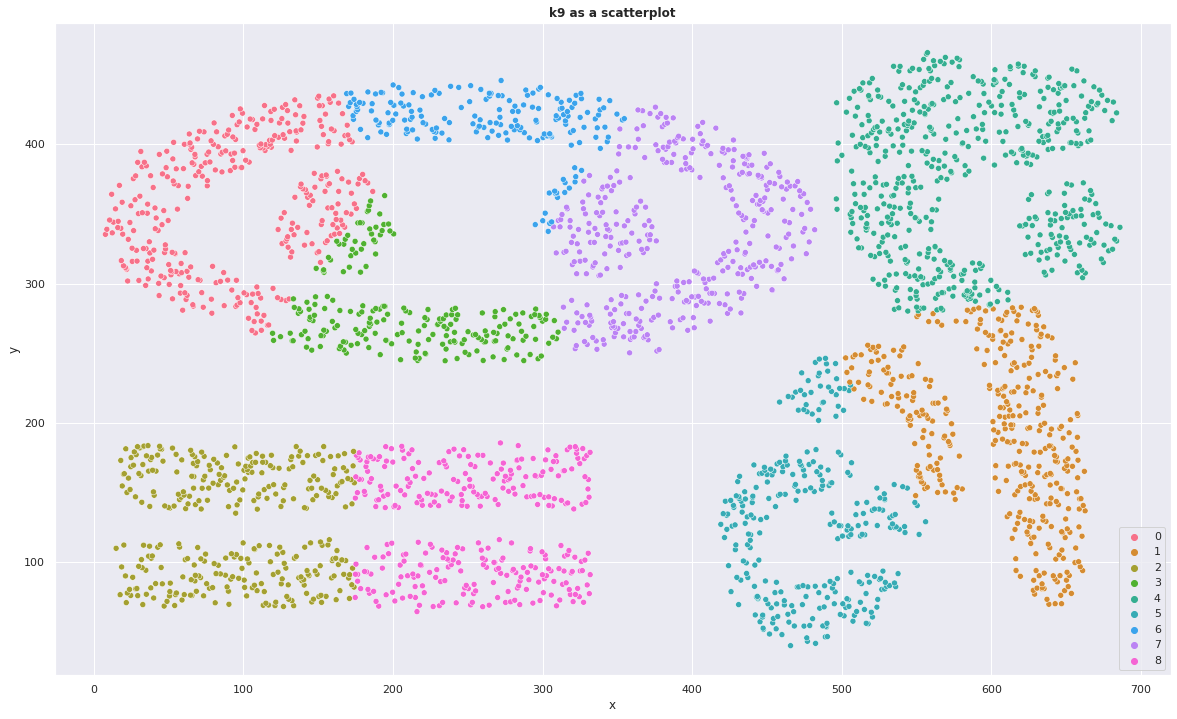

In [9]:
sb.set(rc={'figure.figsize':(20,12)})
sb.scatterplot(data=complex9, x="x", y="y", hue="k9", palette=sb.husl_palette(9)).set_title("k9 as a scatterplot",fontweight='semibold')
plt.legend(loc='lower right')

### for $k$=13

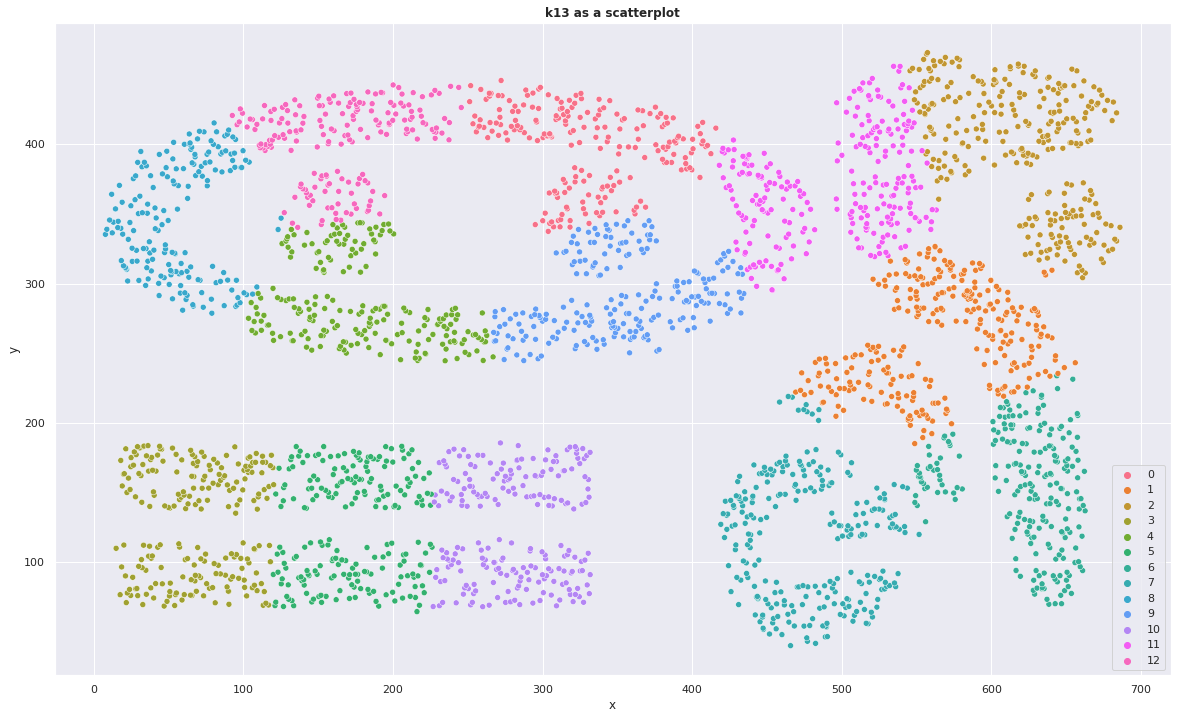

In [10]:
sb.set(rc={'figure.figsize':(20,12)})
sb.scatterplot(data=complex9, x="x", y="y", hue="k13", palette=sb.husl_palette(13)).set_title("k13 as a scatterplot",fontweight='semibold')
plt.legend(loc='lower right')

## Compute their purity using the function you developed in Subtask A

In [11]:
print(f'The purity achieved by KMeans clustering with k=9 was {100*PUR(complex9["k9"], complex9["label"]):.2f}%.')
print(f'The purity achieved by KMeans clustering with k=13 was {100*PUR(complex9["k13"],complex9["label"]):.2f}%.')

The purity achieved by KMeans clustering with k=9 was 72.42%.
The purity achieved by KMeans clustering with k=13 was 68.95%.


## Assess if the K-means clustering was able to "rediscover" the natural clusters of the Complex9 dataset, captured by the "Outcome" attribute of the dataset

No, it was not. Fistly, it's important to note that the KMeans algorithm won't actually discern the number of natural classes, it will simply place all datapoints, as best it can, into 1 of the k number of clusters the user tells it to. Even when we told it the correct number of clusters to place the items into, it still only achieved a ~72.4% purity in those clusters, indicating a substantial error between the classes it predicted for each datapoint and the actual class of that datapoint.

# Subtask C*****
* Run K-means for $k$=3 for the ZPID dataset
* Compute the purity of the obtained clustering result
* Create box plots for all 6 attributes of the obtained 3 clusters and report their centroids
* Create six boxplots for the whole dataset to have a reference point to interpret the boxplots of the three clusters
* Summarize based on the obtained boxplots and centroids what kind of objects each of the 3 clusters contains

## Run K-means for  k =3 for the ZPID dataset

In [12]:
k3ZPID_clustering = KMeans(n_clusters=3).fit(ZPID.iloc[:, :6])#.values)
ZPID["k3"] = k3ZPID_clustering.labels_

In [13]:
ZPID.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome,k3
0,0.639947,0.865041,-0.031990,0.167240,0.468492,1.425995,1,1
1,-0.844885,-1.206228,-0.528319,-0.851551,-0.365061,-0.190672,0,0
2,1.233880,2.015746,-0.693761,-1.331838,0.604397,-0.105584,1,1
3,-0.844885,-1.074719,-0.528319,-0.633239,-0.920763,-1.041549,0,0
4,-1.141852,0.503391,-2.679076,1.549885,5.484909,-0.020496,1,2


## Compute the purity of the obtained clustering result

In [14]:
print(f'The purity achieved by KMeans clustering with k=3 was {100*PUR(ZPID["k3"], pid["Outcome"]):.2f}%.')

The purity achieved by KMeans clustering with k=3 was 67.71%.


## Create box plots for all 6 attributes of the obtained 3 clusters and report their centroids

### Boxplots for all 6 attributes for each of the obtained 3 clusters and for the whole dataset to have a reference point to interpret the boxplots of the three clusters


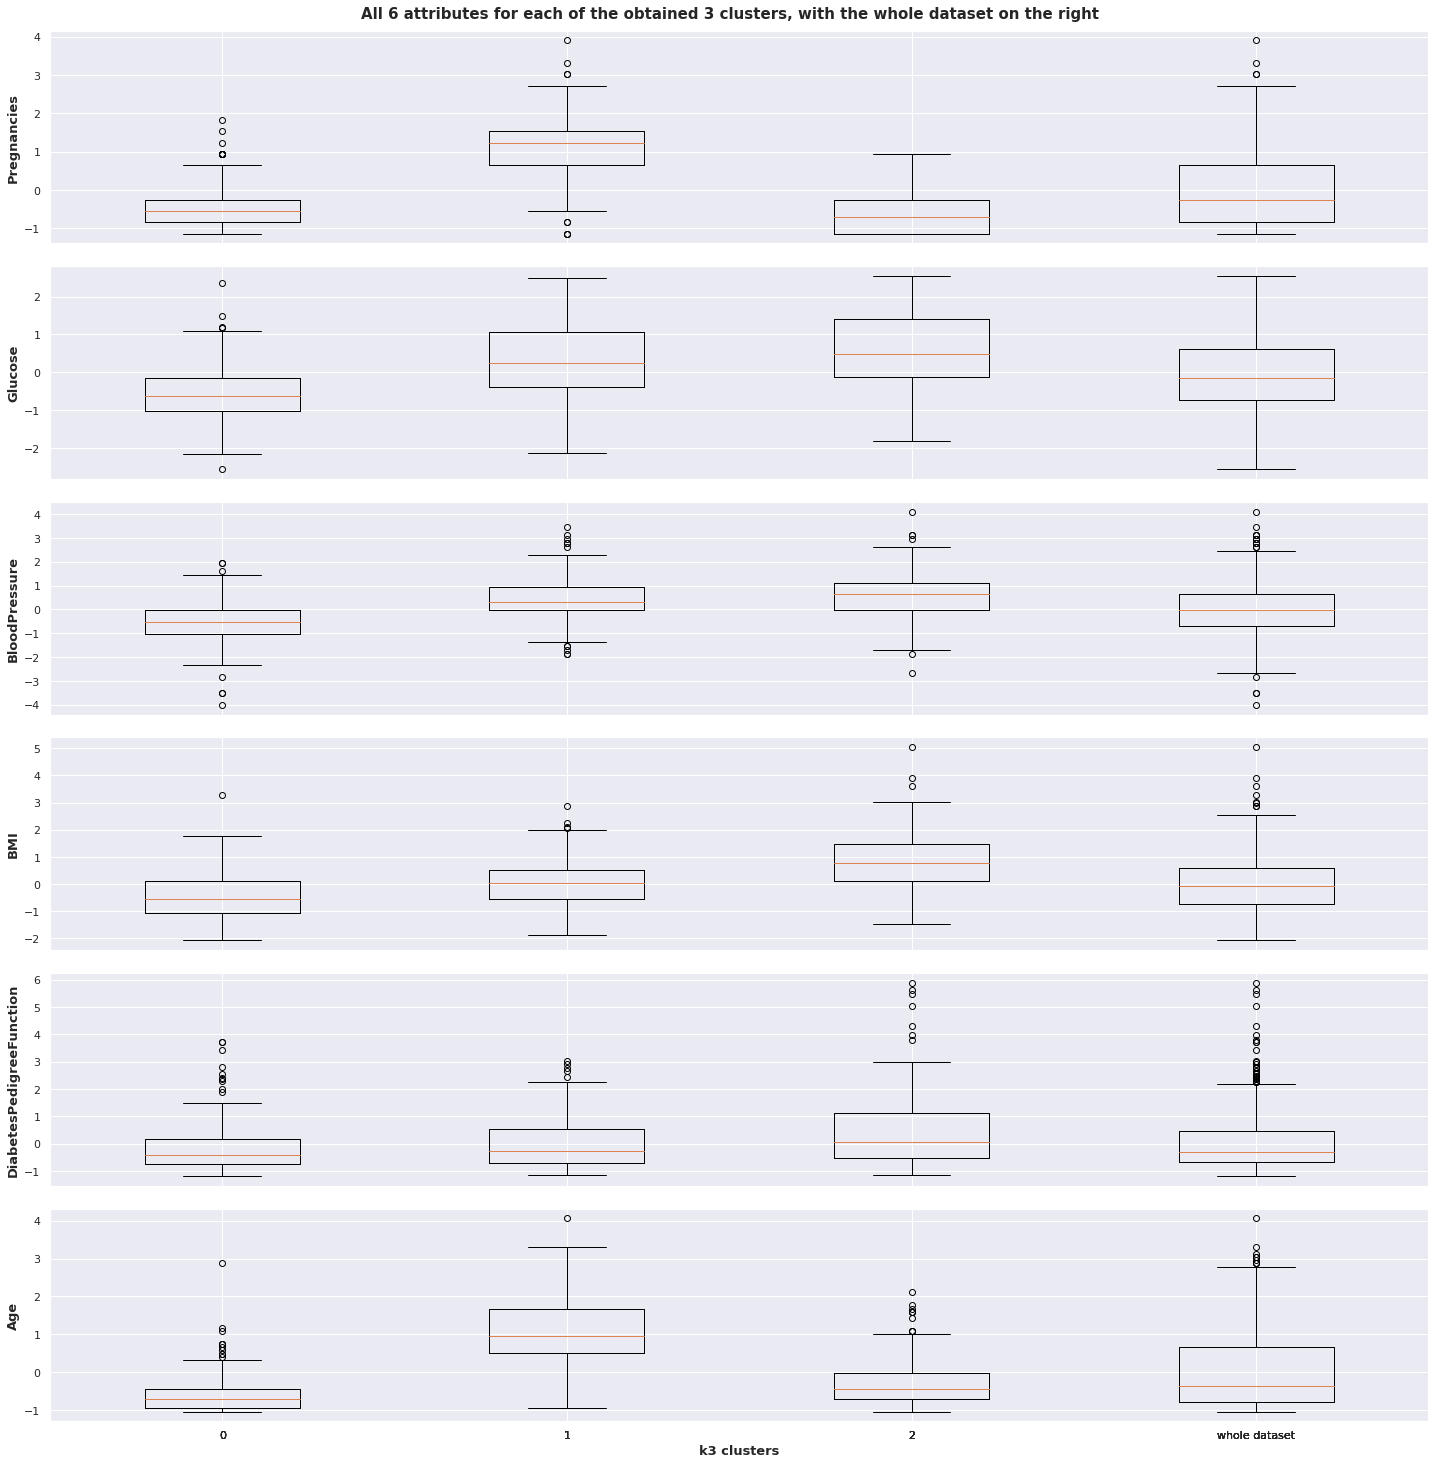

In [15]:
fig, axs = plt.subplots(6,1,sharex=True)
fig.set_size_inches(20,20)
fig.tight_layout()
labelSize = 15
fig.suptitle("All 6 attributes for each of the obtained 3 clusters, with the whole dataset on the right",y=1.005, size=labelSize, fontweight='semibold')
for i in range(6):
  attribute = ZPID.columns[i]
  ax = axs[i]
  data = [ZPID.query(f"k3=={j}")[attribute] for j in range(3)] + [ZPID[attribute]] #for each attribute, make an array of dataframes where each internal dataframe at index=i contains data for that attribute where k3=i
  ax.set_ylabel(attribute, size=labelSize-2, fontweight='semibold')
  if i==5:
    ax.set_xlabel("k3 clusters", size=labelSize-2, fontweight='semibold')
  ax.boxplot(np.array(data,dtype=object), labels = ["0","1","2","whole dataset"])

### Centroids

In [16]:
k3ZPIDcentroids = pd.DataFrame(k3ZPID_clustering.cluster_centers_, columns = ZPID.columns[:6])
k3ZPIDcentroids["k3"] = k3ZPIDcentroids.index
display(k3ZPIDcentroids)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,k3
0,-0.467313,-0.542295,-0.577479,-0.467030,-0.202561,-0.616597,0
1,1.132353,0.364154,0.396111,0.025493,-0.031080,1.136188,1
2,-0.551146,0.568430,0.594715,0.855952,0.424832,-0.272060,2


## Summarize based on the obtained boxplots and centroids what kind of objects each of the 3 clusters contains

Based primarily on the boxplots comparing Glucose (but also on the comparisons of BMI, and Age) it appears that k=0 represents Outcome=0 (non-diabetic), while k=1 and k=2 represent Outcome=1 (diabetic).

# Subtask D**
* Try to obtain a DBSCAN clustering for the ZPID dataset, having between 2 and 15 clusters with less than 20% outliers. 
* Report its purity! Don’t worry if the reported clustering has a low purity. 

In [17]:
e,m = 2, 3
fitObj = DBSCAN(eps=e,min_samples=m).fit(ZPID.iloc[:,:6])
pur = PUR(fitObj.labels_, ZPID["Outcome"], outliers=True)
print(f"For epsilon={e:.1f} and min_samples={m} only {100*pur[1]:.2f}% were outliers and a purity of {100*pur[0]:.2f}% was achieved.")
print(f"This fit resulted in the following groups: {set(fitObj.labels_)}")

For epsilon=2.0 and min_samples=3 only 1.32% were outliers and a purity of 65.30% was achieved.
This fit resulted in the following groups: {0, -1}


# Subtask E
* Develop a search procedure that looks for the “best” clustering by exploring different settings for the (MinPoints, epsilon) parameters of DBSCAN for the Complex9 dataset. The procedure maximizes purity of the obtained clustering, subject to the following constraints:
  1. There should be between 2 and 15 clusters
  2. The number of outliers should be 10% or less.<br/>
  * The procedure returns the “best” DBSCAN clustering found and the accomplished purity as its result
  * Please limit the number of tested (MinPoints, epsilon)-pairs to 3000 in your implementation! You are allowed to run the search procedure 3 times from different starting positions.  
  * Explain how your automated parameter selection method works and demonstrate your automated procedure using an example! 

* Apply the procedure you developed to the Complex9 dataset and report the best clustering you found. Are you happy with the obtained solution?*****<br/>
* If you did not succeed in writing the function that seeks of the optimal DBSCAN clustering, you can manually seek for the best clustering for the Complex 9 dataset and report it
  * If you do this then report how you searched manually for it.***



## Developing the search procedure
This procedure assumes the data has been Z-scored, that way it can work on any normalized dataset.

In [18]:
def bestDBSCAN(data, actual):
  goodParamsAndTheirResults = []
  count = 0
  eMin = 0.0001
  eStep = 0.05
  eCutOff = eMin+55*eStep
  mMin = 1
  mStep = 1
  mCutOff = mMin + 54*mStep
  for e in np.arange(eMin, eCutOff, eStep): # 55 iterations
    for m in range(mMin, mCutOff, mStep):  # 54 iterations, 55*54 = 2970 iterations
      fitObj = DBSCAN(eps=e,min_samples=m).fit(data)
      if len(set(fitObj.labels_))>=2 and len(set(fitObj.labels_))<=15: # 1. There should be between 2 and 15 clusters
        pur = PUR(fitObj.labels_, actual, outliers=True)
        if pur[1] <= 0.1: # 2. The number of outlirs should be 10% or less
          goodParamsAndTheirResults.append([fitObj,pur,e,m])
      count+=1
  print(f"{count} pairs of epsilon and minPoints were tested.")
  goodParamsAndTheirResults.sort(key=lambda x : (x[1][0],-x[1][1]), reverse=True) # after sorting the best will be at index=0
  #      bestDBSCANclusteringFound,              its purity,                all the others that had b/w 2 and 15 clusters and <= 10% outliers
  return goodParamsAndTheirResults[0][0], goodParamsAndTheirResults[0][1], goodParamsAndTheirResults

## Now we Z-score the Complex9 dataset



In [19]:
Zcomplex9 = pd.DataFrame(columns=complex9.columns[:3])
for col in Zcomplex9.columns:
  if col != "label":
    Zcomplex9[col] = zscore(complex9[col])
  else:
    Zcomplex9[col] = complex9[col]
Zcomplex9.head()

,x,y,label
0,1.514793,0.364777,0
1,1.390288,0.381250,0
2,1.523728,0.393006,0
3,1.497251,0.394486,0
4,1.385562,0.398010,0


## Using the procedure
Here I will apply the procedure I developed to the Z-scored Complex9 dataset (Zcomplex9) as an example and then report the best clustering I found. 

In [20]:
best, pur, all = bestDBSCAN(Zcomplex9.iloc[:,:2], Zcomplex9["label"]) # takes about 5 minutes to run
e,m = all[0][2], all[0][3]
print(f"For epsilon={e:.4f} and min_samples={m} only {100*pur[1]:.2f}% were outliers and a purity of {100*pur[0]:.2f}% was achieved.")
print(f"This fit resulted in the following clusterings and counts:")
clustersCounts = pd.DataFrame(columns=["clusters","counts"])
for i in set(best.labels_):
  clustersCounts.loc[len(clustersCounts)] = [i,list(best.labels_).count(i)]
display(clustersCounts.style.hide_index())

2970 pairs of epsilon and minPoints were tested.
For epsilon=0.1001 and min_samples=8 only 0.07% were outliers and a purity of 100.00% was achieved.
This fit resulted in the following clusterings and counts:


clusters,counts
0,87
1,113
2,110
3,202
4,198
5,343
6,906
7,328
8,742
-1,2


## Visualizing the results as a scatterplot

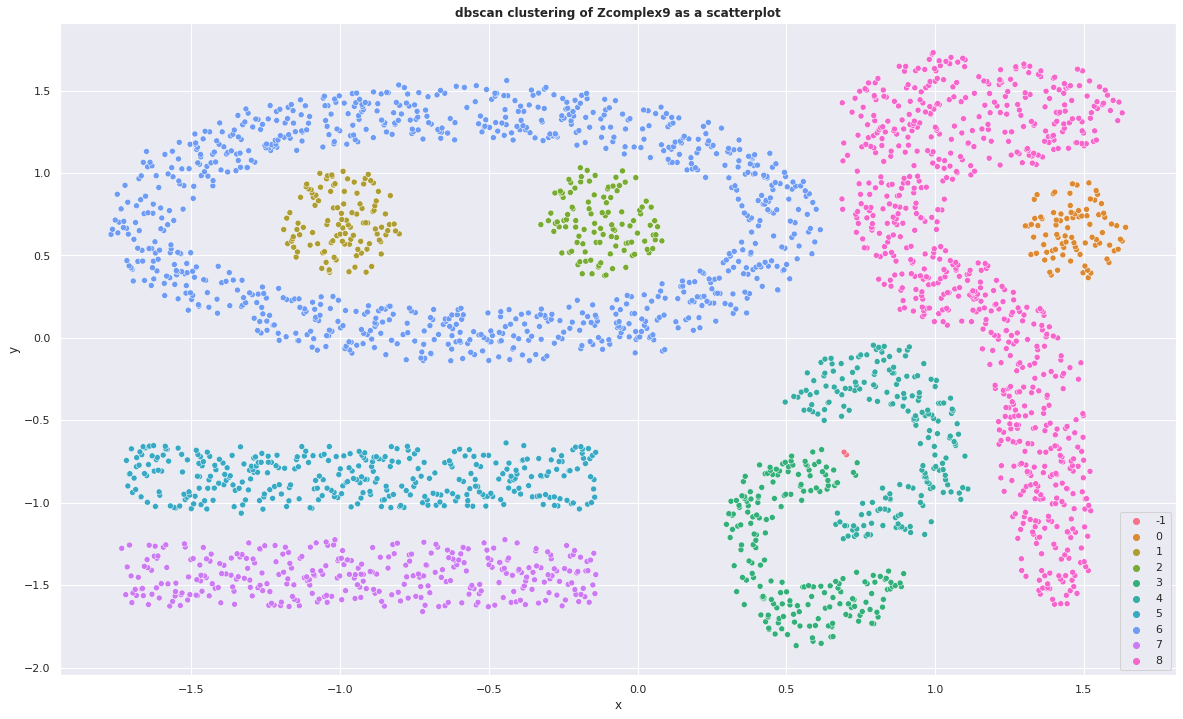

In [21]:
Zcomplex9["dbscan"] = best.labels_
sb.set(rc={'figure.figsize':(20,12)})
sb.scatterplot(data=Zcomplex9, x="x", y="y", hue="dbscan", palette=sb.husl_palette(len(set(best.labels_)))).set_title("dbscan clustering of Zcomplex9 as a scatterplot",fontweight='semibold')
plt.legend(loc='lower right')
Zcomplex9.drop(columns="dbscan", inplace=True)

## Discussion
The bestDBSCAN(data,actual) function works by assuming that the data passed in has been Z-scored, that way the range for epsilon can begin from the same start point (if the data wasn't normalized then the scales of distances between points would be different depending on the dataset's attributes' scales). The procedure creates an empty list, goodParamsAndTheirResults, into which the procedure will place parameters, their resulting clustering, and the purity of that clustering, provided the stipulated specifications are met (between 2 and 15 clusters, and no more than 10% outliers). The procedure then uses two forloops, the outer-forloop which iterates over proposed values of epsilon (e), and the inner-forloop which iterates over proposed values of minSamples (m). Because of how these forloops' ranges were set up, they will iterate 2970 times. Inside the inner-most forloop a DBSCAN object is created and fit to the passed in data. If that clustering has between 2 and 15 clusters then its predicted labels and the actual, known labels are passed to the PUR() function for evaluation. If the % outliers is less than 10% then that cluster has met all specifications and it, its PUR results, and the parameters which produced it are added to the goodParamsAndTheirResults list. After completing the forloops the procedure then sorts the goodParamsAndTheirResults list such that highest purity clusterings come first, prioritizing lower percentages of outliers whenever there are ties between purities. Finally the procedure returns 3 things: 
1. The best clustering found
2. The best clustering's purity
3. The sorted list of all qualifiying clusterings, their purities, and their parameters

I am quite happy with the achieved maximum purity and its associated marginal outlier percentage.



# Extra Credit
Apply your search procedure also to the cleaned Pima Indian Diabetes Dataset and report the clusters of the best result and what purity you accomplished.*

## Running the function and reporting results

In [22]:
best, pur, all = bestDBSCAN(ZPID.iloc[:,:6], ZPID["Outcome"]) # takes about 5 minutes to run
e,m = all[0][2], all[0][3]
print(f"For epsilon={e:.1f} and min_samples={m} only {100*pur[1]:.2f}% were outliers and a purity of {100*pur[0]:.2f}% was achieved.")
print(f"This fit resulted in the following clusterings and counts:")
clustersCounts = pd.DataFrame(columns=["clusters","counts"])
for i in set(best.labels_):
  clustersCounts.loc[len(clustersCounts)] = [i,list(best.labels_).count(i)]
display(clustersCounts.style.hide_index())

2970 pairs of epsilon and minPoints were tested.
For epsilon=1.4 and min_samples=2 only 8.94% were outliers and a purity of 68.09% was achieved.
This fit resulted in the following clusterings and counts:


clusters,counts
0,688
1,3
2,4
3,3
4,3
5,2
6,2
-1,63
